In [126]:
import sys

sys.path.append('C:\\Users\\erik_\\Documents\\erik documents\\Programas\\PlasmaSimulations\\src')
# sys.path.append('...\\PlasmaSimulations\\src') # Replace dots with personal directory

%matplotlib inline
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt
import os

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.animation as animation
# plt.rcParams['animation.html'] = 'html5'

from IPython import display
import time
import ffmpeg

import VlasovSolver

# Landau damping

### Initial Condition of the model:

$$ f(0,x,v) =  \frac{1}{\sqrt{2 \pi}} e^{-v^2/2} (1+\varepsilon\cos(kx))$$

for $k$ $\in$ {0.5,0.4,0.3,0.2} and $L_x = 2\pi/k$

Here $\varepsilon$ controls the perturbation, values of $\varepsilon < 0.5$ leads to a linear Landau Damping whilst $\varepsilon \leq 0.5$ leads to the non linear Landau damping. $k$ is the wave number.

## 1. Non Linear Landau Damping 

#### Parameters

- $\varepsilon$ = 0.5
- $k$ = 0.5
- $v\in(-10,10)$
- $x\in(0,2\pi/k)$

In [35]:
eps = 0.5 # perturbation parameter
v_min = -10 # Minimum velocity 
v_max = 10 # Maximum velocity
T_max = 35 # Max time of solution
k_param = 0.5 # wave number
L_x = 2*np.pi / k_param # Size of grid
L_x

#### Initial Condition

In [37]:
def landau_initial_cond(x,v):
    return (1.0/np.sqrt(2.0*np.pi)) * np.exp(-v**2/2.0) * (1.0 + eps*np.cos(k_param*x))

#### Discretization

In [39]:
N_x = 256 # Position Slots 
N_y = 256 # Velocities Slots 
M_size = 6000 # Divisions of time in M slots 

# Step Sizes:
dx = L_x/N_x
dv = (v_max-v_min)/N_y
dt = T_max/M_size

print(f'Nx: {N_x}     dx: {dx}')
print(f'Ny: {N_y}    dy: {dv}')
print(f'M:  {M_size}   dt: {dt}')

Nx: 256     dx: 0.04908738521234052
Ny: 256    dy: 0.078125
M:  6000   dt: 0.005833333333333334


#### Run Model

In [40]:
start_time = time.time()

objSolver = VlasovSolver.VlasovPoisson1D1V(landau_initial_cond, 0.0 ,L_x , N_x, v_min, v_max, N_y, T_max, M_size, 
                                                 'Spectral', 1 ,'Landau_Damping1')
Mass_sol,Moment_sol,Energy_sol,L2norm_sol,E_field = objSolver.run_iteration() # run model

end_time = time.time()
print('Total execution time: ',(end_time-start_time)/60.)

Total execution time:  12.23392497698466


In [41]:
t_grid = objSolver.grid_points(0.0,T_max,dt)[:-1]
t_grid.shape

(6000,)

### Plot the variables evolution in time (Mass, Momentum, Energy and $L^2$ Norm)

In [153]:
def plot_quantity(t_array,var_array,label,var_name,dtime):
    plt.figure(figsize=(10,8))
    plt.plot(t_array,var_array,label = label,c='b')
    plt.title(f"Conservation of Total {var_name} for dt: "+ "%.3f"%dtime,fontsize=15)
    plt.xlabel('Time',fontsize=14)
    plt.ylabel(f'{var_name}',fontsize=14)
    plt.legend()
    plt.show()

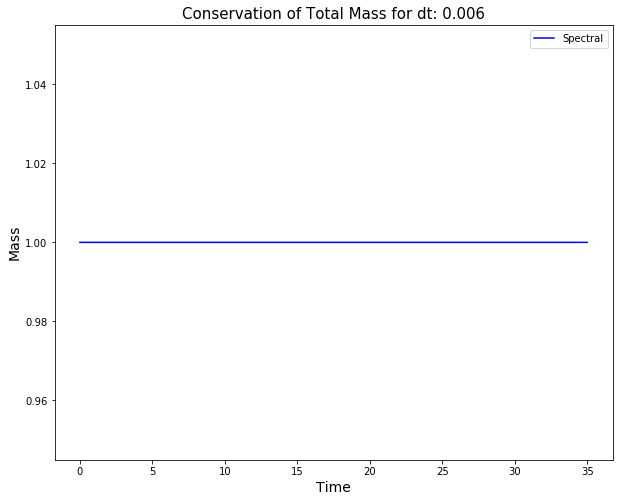

In [154]:
plot_quantity(t_grid,Mass_sol/Mass_sol[0],'Spectral','Mass',dt)

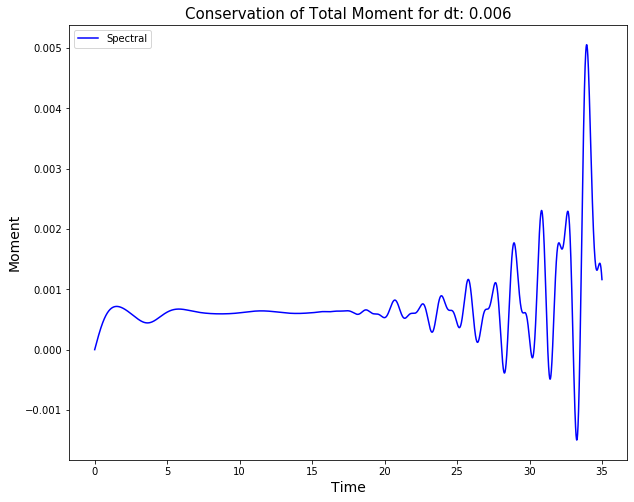

In [155]:
plot_quantity(t_grid,Moment_sol,'Spectral','Moment',dt)

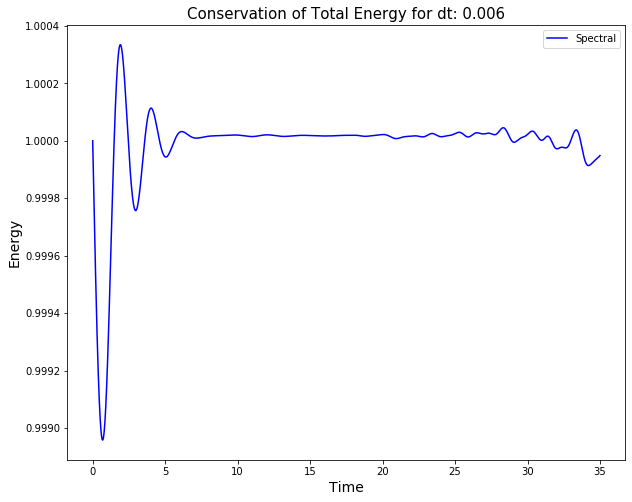

In [156]:
plot_quantity(t_grid,Energy_sol/Energy_sol[0],'Spectral','Energy',dt)

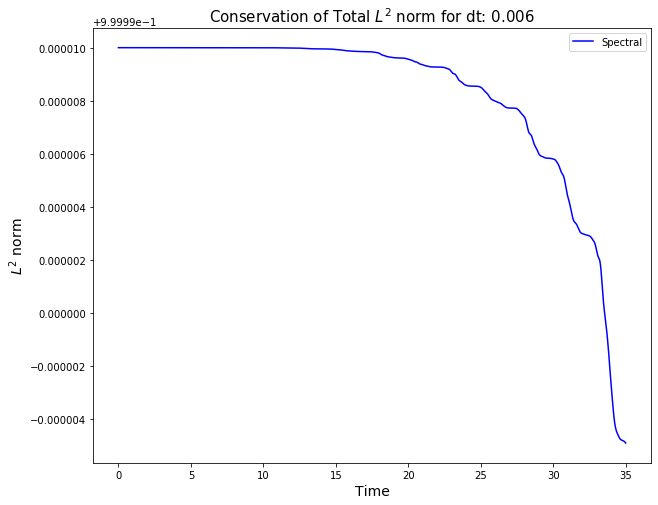

In [157]:
plot_quantity(t_grid,L2norm_sol/L2norm_sol[0],'Spectral','$L^2$ norm',dt)

### Open File

In [47]:
data_Landau1 = np.loadtxt("Landau_Damping1.txt")
data_Landau1 = data_Landau1.reshape(M_size+1,N_y+1,N_x+1)
data_Landau1.shape

(6001, 257, 257)

### Plot the distribution function

In [48]:
x_array = np.arange(0, L_x + dx, dx) # positions array
v_array = np.arange(v_min, v_max + dv, dv) # velocities array
Pos,Vel = np.meshgrid(x_array,v_array) # space-velocity mesh grid

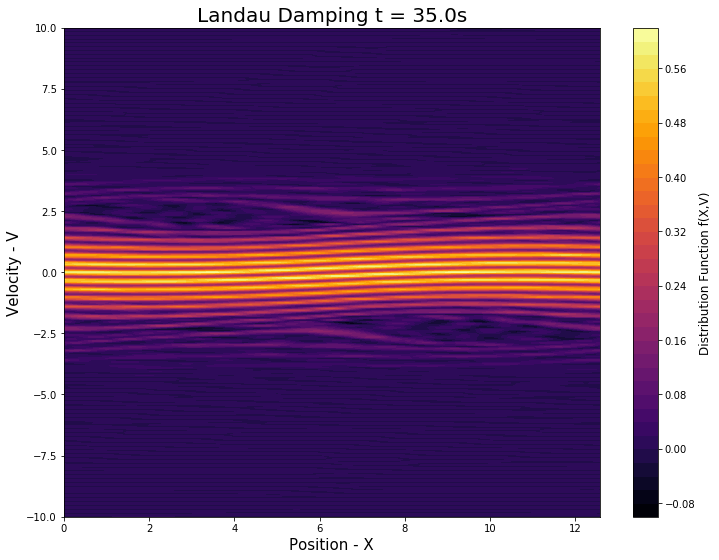

In [113]:
fig,ax = plt.subplots(1,1,figsize = (12, 9))
ti = 6000 # time to plot
cp = ax.contourf(Pos, Vel , data_Landau1[ti],40, cmap=cm.inferno) # Create contour plot
cbar = fig.colorbar(cp) # Add a colorbar to a plot
cbar.ax.set_ylabel('Distribution Function f(X,V)',fontsize = 12) # Label the color bar
plt.title(f'Landau Damping t = {ti*dt}s',fontsize = 20) # title
ax.set_xlabel('Position - X',fontsize = 15) # xlabel
ax.set_ylabel('Velocity - V',fontsize = 15) # ylabel
plt.show()

In [98]:
time_plot = [0, 1200, 2400, 3600, 4800, 6000] #times to plot

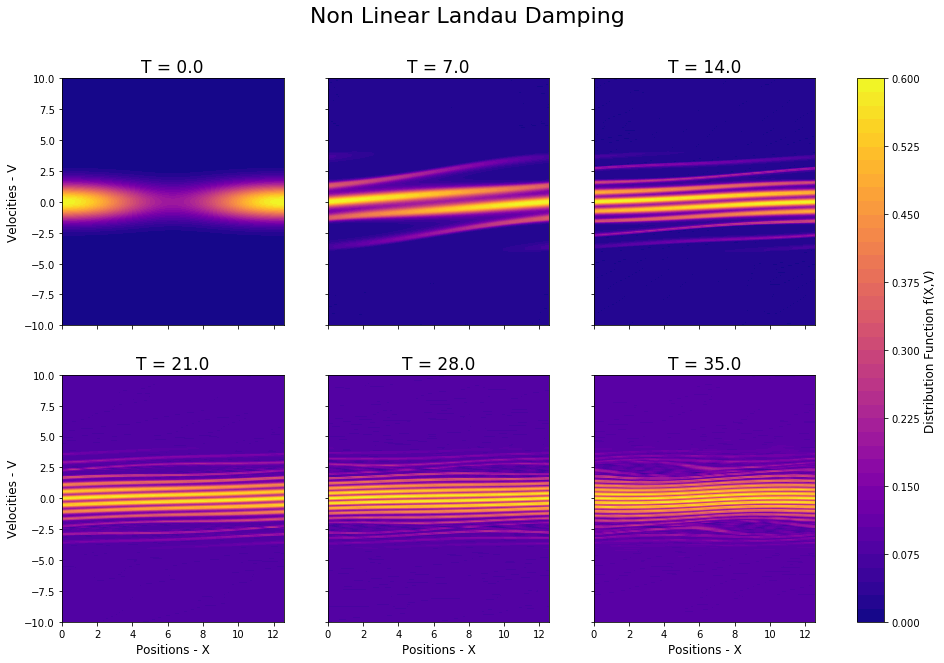

In [108]:
### Create plots of the distribution function at different times

fig, ax = plt.subplots(2, 3,figsize=(15,10))
fig.suptitle('Non Linear Landau Damping',fontsize = 22) # general title

ti = 0 # index counter
images = [] # list to store images

for i in range(2): 
    for j in range(3):
        cp = ax[i,j].contourf(Pos, Vel, data_Landau1[time_plot[ti]], 50, cmap = cm.plasma) # create contour 
        ax[i,j].set_title(f'T = {time_plot[ti]*dt}',fontsize = 17) # create title
        images.append(cp) # save contour in list
        ti+=1 
        
# Add x and y labels
for axx in ax.flat:
    axx.set_xlabel('Positions - X',fontsize = 12)
    axx.set_ylabel('Velocities - V',fontsize = 12)

# Add a colorbar to a plot
cbar = fig.colorbar(images[0], ax=ax, orientation='vertical', fraction=.05)
cbar.ax.set_ylabel('Distribution Function f(X,V)',fontsize = 12)
    
# Hide x labels and tick labels for top plots and y ticks for right plots.
for axx in ax.flat:
    axx.label_outer()

### Field Energy History

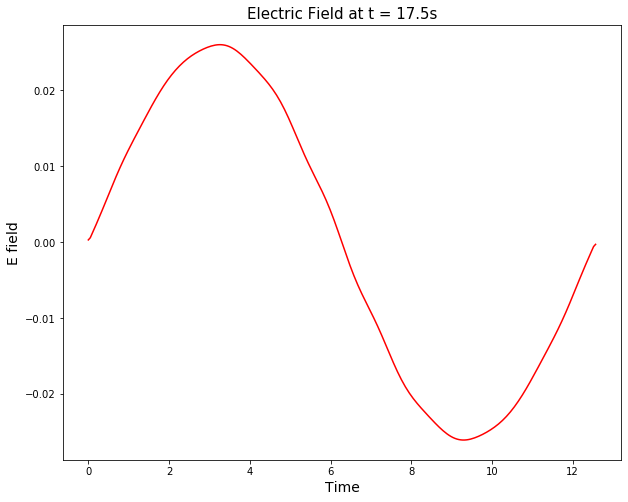

In [158]:
plt.figure(figsize=(10,8))
tt = 3000
plt.plot(x_array, E_field[tt],c='r')
plt.title(f'Electric Field at t = {tt*dt}s',fontsize=15)
plt.xlabel('Time',fontsize=14)
plt.ylabel('E field',fontsize=14)
plt.show()

#### We integrate the electric field vs position

Field Energy: 
$$ \int |\nabla \phi|^2 dx = \int |E(x)|^2 dx $$

In [132]:
integralEf=[]
for ef in E_field:
    integral = integrate.trapz(abs(ef), dx = dx)
    integralEf.append(integral)

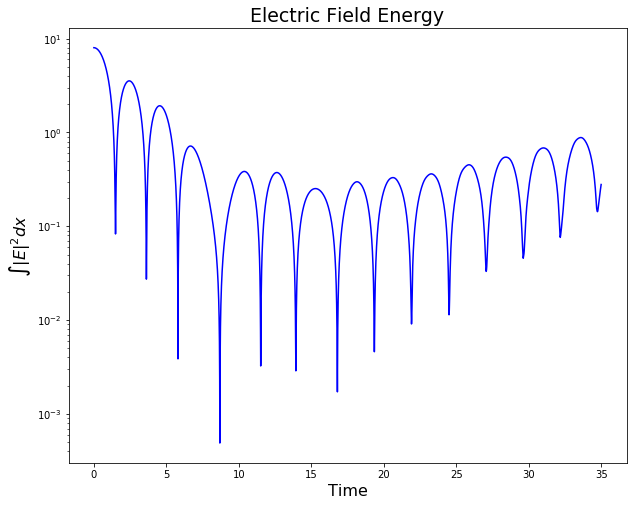

In [159]:
plt.figure(figsize=(10,8))
plt.plot(t_grid, integralEf,c='b')
plt.title('Electric Field Energy',fontsize=19)
plt.xlabel('Time',fontsize=16)
plt.ylabel('$\int|E|^2 dx$',fontsize=16)
plt.yscale('log')
plt.show()